# Predicción de Ventas Retail con Efectos Promocionales

**Autores:** Álvaro Hernández Rubio, Luis Carlos Deza Monge

**Objetivo:** Desarrollar un modelo de predicción de ventas que capture el efecto de descuentos promocionales en productos retail.

**Dataset:** The Complete Journey (Dunnhumby) https://www.kaggle.com/datasets/frtgnn/dunnhumby-the-complete-journey/data

**Metodología:** Arquitectura de dos etapas
- Modelo A: Baseline (ventas sin promoción) usando OLS
- Modelo B: Lift incremental (efecto promocional) usando XGBoost/CatBoost


## 1. Carga de Datos

Importación de librerías necesarias y carga del dataset The Complete Journey.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Lectura de datos

*Añadir .csv a content en google colab

In [2]:
df_campaign_desc = pd.read_csv('campaign_desc.csv')
df_campaign_table = pd.read_csv('campaign_table.csv')
df_causal_data = pd.read_csv('causal_data.csv')
df_coupon_redempt = pd.read_csv('coupon_redempt.csv')
df_coupon = pd.read_csv('coupon.csv')
df_hh_demographic = pd.read_csv('hh_demographic.csv')
df_product = pd.read_csv('product.csv')
df_transaction_data = pd.read_csv('transaction_data.csv')

In [3]:
df_transaction_data.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [4]:
df_product.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


## 2. Preparación y Limpieza de Datos

Pasos de preparación:
- Filtrado de semanas iniciales (≥16)
- Merge con información de productos
- Eliminación de productos outlier
- Selección de productos modelables (≥2 uds/semana, ≥40% presencia)

In [5]:
# Filtrar semanas iniciales
SEMANA_INICIO = 16
df_transaction_data = df_transaction_data[df_transaction_data["WEEK_NO"] >= SEMANA_INICIO].copy()

# Merge con info de producto
df_merge = df_transaction_data.merge(df_product, how='left', on='PRODUCT_ID')

In [6]:
df_merge

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,2024,28210568733,104,849870,1,2.79,432,0.00,106,16,0.0,0.0,1102,GROCERY,National,BAKED SWEET GOODS,SWEET GOODS - FULL SIZE,14 OZ
1,2024,28210568733,104,865501,1,1.25,432,-0.14,106,16,0.0,0.0,1305,GROCERY,National,CRACKERS/MISC BKD FD,SOUP CRACKERS (SALTINE/OYSTER),6 OZ
2,2024,28210568733,104,1033142,1,0.71,432,0.00,106,16,0.0,0.0,2,PRODUCE,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB
3,2024,28210568733,104,1036347,1,2.59,432,0.00,106,16,0.0,0.0,1075,GROCERY,National,CRACKERS/MISC BKD FD,SOUP CRACKERS (SALTINE/OYSTER),16 OZ
4,2024,28210568733,104,1069003,1,3.99,432,0.00,106,16,0.0,0.0,988,GROCERY,National,CHEESE,SHREDDED CHEESE,12 OZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2422063,1598,42305362535,711,92130,1,0.99,3228,0.00,1520,102,0.0,0.0,560,GROCERY,National,MARGARINES,MARGARINE: TUBS AND BOWLS,16 OZ
2422064,1598,42305362535,711,114102,1,8.89,3228,0.00,1520,102,0.0,0.0,2398,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,12 OZ
2422065,1598,42305362535,711,133449,1,6.99,3228,0.00,1520,102,0.0,0.0,2468,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,12 OZ
2422066,1598,42305362535,711,6923644,1,4.50,3228,-0.49,1520,102,0.0,0.0,2390,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,4PK/10 OZ


Seleccionamos artículos

In [7]:

# Filtrar productos estables
umbral_estabilidad = 0.70
top_n = 100

# Eliminar productos siempre en promoción
productos_siempre_promo = (
    df_merge.groupby("PRODUCT_ID")["RETAIL_DISC"]
    .apply(lambda s: (s != 0).all())
)
df_merge = df_merge[~df_merge["PRODUCT_ID"].isin(productos_siempre_promo[productos_siempre_promo].index)]

# Estabilidad por producto
total_weeks = df_merge["WEEK_NO"].nunique()  # total semanas disponibles en el dataset (tras quitar siempre promo)
prod_weeks = (
    df_merge.groupby("PRODUCT_ID")["WEEK_NO"]
    .nunique()
    .reset_index(name="weeks_product")
)
prod_weeks["pct_estabilidad"] = prod_weeks["weeks_product"] / total_weeks

# Productos con descuento alguna vez
prod_desc = df_merge.groupby("PRODUCT_ID")["RETAIL_DISC"].apply(lambda s: (s != 0).any())
prod_weeks["tuvo_desc"] = prod_weeks["PRODUCT_ID"].map(prod_desc)

# Top productos
candidatos = prod_weeks[(prod_weeks["tuvo_desc"]) & (prod_weeks["pct_estabilidad"] >= umbral_estabilidad)]

top100_product_ids = (
    df_transaction_data[df_transaction_data["PRODUCT_ID"].isin(candidatos["PRODUCT_ID"])]
    .groupby("PRODUCT_ID")["QUANTITY"].sum()
    .sort_values(ascending=False)
    .head(top_n).index.tolist()
)

print("Total semanas:", total_weeks)
print("Candidatos:", len(candidatos))
print("Top IDs seleccionados:", len(top100_product_ids))


Total semanas: 87
Candidatos: 3640
Top IDs seleccionados: 100


En este paso, se realiza el dataset final (wk) con variables de ventas, precios, descuento, lags y estacionalidad. Tambien se procedo a elimiar el outlier por lo que de tener 100 prodcutos, ahora solo hay 99 prodcutos.

In [8]:
tx = df_transaction_data[df_transaction_data["PRODUCT_ID"].isin(top100_product_ids)].copy()

tx["SALES_NET"] = tx["SALES_VALUE"]
tx["RETAIL_DISC_AMT"] = tx["RETAIL_DISC"]
tx["SALES_NO_DISCOUNT"] = tx["SALES_NET"] + tx["RETAIL_DISC_AMT"].abs()

wk = tx.groupby(["PRODUCT_ID","STORE_ID","WEEK_NO"], as_index=False).agg({
    "QUANTITY":"sum",
    "SALES_NET":"sum",
    "SALES_NO_DISCOUNT":"sum",
    "RETAIL_DISC_AMT":"mean"
})

wk["PRICE"] = wk["SALES_NET"] / wk["QUANTITY"]
wk["PRICE_BASE"] = wk["SALES_NO_DISCOUNT"] / wk["QUANTITY"]
wk["DISC_PCT"] = ((wk["PRICE_BASE"] - wk["PRICE"]) / wk["PRICE_BASE"]).fillna(0).clip(0,0.9)

all_weeks = np.arange(wk["WEEK_NO"].min(), wk["WEEK_NO"].max()+1)
grid = wk[["PRODUCT_ID","STORE_ID"]].drop_duplicates().assign(key=1)\
    .merge(pd.DataFrame({"WEEK_NO":all_weeks,"key":1}), on="key").drop("key",axis=1)

wk = grid.merge(wk, on=["PRODUCT_ID","STORE_ID","WEEK_NO"], how="left").fillna(0)
wk = wk.sort_values(["PRODUCT_ID","STORE_ID","WEEK_NO"])

for lag in [1,2,4,12]:
    wk[f"LAG_{lag}"] = wk.groupby(["PRODUCT_ID","STORE_ID"])["QUANTITY"].shift(lag)

wk["WEEK_SIN"] = np.sin(2*np.pi*wk["WEEK_NO"]/52)
wk["WEEK_COS"] = np.cos(2*np.pi*wk["WEEK_NO"]/52)
wk["WEEK_OF_MONTH"] = ((wk["WEEK_NO"]-1)%4)+1


In [9]:
#  Limpieza de outlier

print("\nEliminando producto outlier de ventas extremas...")

wk = wk[wk["PRODUCT_ID"] != 6534178].copy()

print("Productos restantes:", wk["PRODUCT_ID"].nunique())


Eliminando producto outlier de ventas extremas...


Productos restantes: 99


In [10]:
# DIAGNÓSTICO DE DEMANDA POR PRODUCTO

print("\n" + "="*60)
print("DIAGNÓSTICO DE DEMANDA DEL SURTIDO")

ventas_media = wk.groupby("PRODUCT_ID")["QUANTITY"].mean()
pct_semanas_con_venta = wk.groupby("PRODUCT_ID")["QUANTITY"].apply(lambda x: (x > 0).mean())

resumen = pd.DataFrame({
    "media_ventas_semana": ventas_media,
    "pct_semanas_con_venta": pct_semanas_con_venta
}).sort_values("media_ventas_semana", ascending=False)

print("\nTop 10 productos por ventas medias:")
print(resumen.head(10))

print("\nProductos con demanda continua (>5 uds/semana y venta en >50% semanas):",
      ((resumen["media_ventas_semana"] > 5) & (resumen["pct_semanas_con_venta"] > 0.5)).sum())

print("Productos con demanda intermitente (venta en <30% semanas):",
      (resumen["pct_semanas_con_venta"] < 0.3).sum())

# Detectar outliers extremos
q99 = resumen["media_ventas_semana"].quantile(0.99)
outliers = resumen[resumen["media_ventas_semana"] > q99]

print("\nProductos outlier de ventas extremas:")
print(outliers)



DIAGNÓSTICO DE DEMANDA DEL SURTIDO

Top 10 productos por ventas medias:
            media_ventas_semana  pct_semanas_con_venta
PRODUCT_ID                                            
1082185                2.899980               0.828292
995242                 2.073704               0.556665
1029743                1.596088               0.620387
1133018                1.160012               0.403811
981760                 1.079646               0.513885
1106523                1.078443               0.512805
1007195                0.891490               0.126648
883404                 0.844878               0.423151
866227                 0.759449               0.220980
995785                 0.741581               0.355314

Productos con demanda continua (>5 uds/semana y venta en >50% semanas): 0
Productos con demanda intermitente (venta en <30% semanas): 77

Productos outlier de ventas extremas:
            media_ventas_semana  pct_semanas_con_venta
PRODUCT_ID                         

In [11]:
# Mantener solo productos con demanda suficiente
productos_modelables = resumen[
    (resumen["media_ventas_semana"] >= 2) &
    (resumen["pct_semanas_con_venta"] >= 0.4)
].index

wk = wk[wk["PRODUCT_ID"].isin(productos_modelables)].copy()

print("\nProductos usados para modelar:", len(productos_modelables))


Productos usados para modelar: 2


Como se aprecia en el fragmento del codigo de arriba nos quedamos solo con 2 productos debido a que estos cumplen una presencia minima del 40% de semanas y evntas promedio mayor o igual a 2 unidades por semana



## 3. Feature Engineering

Creación de variables para modelado:
- **LAGs temporales:** Ventas de semanas anteriores (1, 2, 4, 12)
- **Estacionalidad:** Sin/Cos semanal, semana del mes
- **Precio:** Precio neto, precio base, porcentaje de descuento

## 4. Modelo A: Baseline (Ventas sin Promoción)

Regresión OLS para estimar ventas base en ausencia de promoción.

**Variables independientes:** PRICE, LAG_1, LAG_2, LAG_4, LAG_12, WEEK_SIN, WEEK_COS, WEEK_OF_MONTH

**Muestra:** Solo artículos sin promoción: DISC_PCT = 0 y WEEK_NO ≤ 80

In [12]:
features_A_ols = ["PRICE","LAG_1","LAG_2","LAG_4","LAG_12","WEEK_SIN","WEEK_COS","WEEK_OF_MONTH"]

wk_A_train = wk[(wk["DISC_PCT"]==0) & (wk["WEEK_NO"]<=80)].copy()

# Reemplazar infinitos por NaN
wk_A_train[features_A_ols] = wk_A_train[features_A_ols].replace([np.inf, -np.inf], np.nan)

# Eliminar filas con NaN en features o target
wk_A_train = wk_A_train.dropna(subset=features_A_ols + ["QUANTITY"])

print("Observaciones usadas en OLS:", len(wk_A_train))

X_A = sm.add_constant(wk_A_train[features_A_ols].astype(float), has_constant="add")
y_A = wk_A_train["QUANTITY"].astype(float)

modelA_ols = sm.OLS(y_A, X_A).fit()
print(modelA_ols.summary())

Observaciones usadas en OLS: 8330


                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     927.3
Date:                Sat, 14 Feb 2026   Prob (F-statistic):               0.00
Time:                        17:38:46   Log-Likelihood:                -15740.
No. Observations:                8330   AIC:                         3.150e+04
Df Residuals:                    8321   BIC:                         3.156e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2263      0.049     -4.580

Definimos Baseline_Pred que es lo que usaremos como una nueva entrada en el modelo B

In [13]:
def predecir_baseline_ols(df):
    X = sm.add_constant(df[features_A_ols].astype(float), has_constant='add')
    return modelA_ols.predict(X).clip(0)

train_data = wk[wk["WEEK_NO"]<=80].copy()
test_data  = wk[wk["WEEK_NO"]>80].copy()

train_data["BASELINE_PRED"] = predecir_baseline_ols(train_data)
test_data["BASELINE_PRED"]  = predecir_baseline_ols(test_data)

wk = pd.concat([train_data, test_data]).sort_values(["PRODUCT_ID","STORE_ID","WEEK_NO"])

## 5. Modelo B: Lift Promocional

Predicción del incremento de ventas causado por descuentos.

**Target:** LIFT = QUANTITY - BASELINE_PRED

**Features:** BASELINE_PRED, DISC_PCT, LAGs, estacionalidad, PROD_MEAN_SALES, STORE_MEAN_SALES

**Modelos evaluados:** Linear Regression, XGBoost, CatBoost

In [14]:
train = wk[wk["WEEK_NO"]<=80].copy()
test  = wk[wk["WEEK_NO"]>80].copy()

prod_means = train.groupby("PRODUCT_ID")["QUANTITY"].mean()
store_means = train.groupby("STORE_ID")["QUANTITY"].mean()

train["PROD_MEAN_SALES"] = train["PRODUCT_ID"].map(prod_means)
train["STORE_MEAN_SALES"] = train["STORE_ID"].map(store_means)

test["PROD_MEAN_SALES"] = test["PRODUCT_ID"].map(prod_means)
test["STORE_MEAN_SALES"] = test["STORE_ID"].map(store_means)

global_mean = train["QUANTITY"].mean()
test["PROD_MEAN_SALES"].fillna(global_mean, inplace=True)
test["STORE_MEAN_SALES"].fillna(global_mean, inplace=True)

#  TARGET CORRECTO: LIFT EN UNIDADES
train["LIFT"] = train["QUANTITY"] - train["BASELINE_PRED"]
test["LIFT"]  = test["QUANTITY"] - test["BASELINE_PRED"]



features_B = [
    "BASELINE_PRED","DISC_PCT",
    "LAG_1","LAG_2","LAG_4","LAG_12",
    "WEEK_SIN","WEEK_COS","WEEK_OF_MONTH",
    "PROD_MEAN_SALES","STORE_MEAN_SALES"
]


# Reemplazar infinitos por NaN (por seguridad)
train[features_B] = train[features_B].replace([np.inf, -np.inf], np.nan)
test[features_B]  = test[features_B].replace([np.inf, -np.inf], np.nan)


train = train.dropna(subset=features_B + ["LIFT"])
test  = test.dropna(subset=features_B + ["LIFT"])

X_train, y_train = train[features_B], train["LIFT"]
X_test, y_test   = test[features_B], test["LIFT"]

# # Eliminar filas con NaN SOLO después de crear todas las features
# train = train.dropna(subset=features_B + ["QUANTITY"])
# test  = test.dropna(subset=features_B + ["QUANTITY"])

# X_train, y_train = train[features_B], train["QUANTITY"]
# X_test, y_test   = test[features_B], test["QUANTITY"]

models = {
    "Linear": LinearRegression(),
    "XGBoost": XGBRegressor(n_estimators=400,max_depth=6,learning_rate=0.05),
    "CatBoost": CatBoostRegressor(iterations=400,verbose=0)
}

print("\n Error MAE en LIFT (no ventas totales)")
for name, m in models.items():
    m.fit(X_train,y_train)
    lift_pred = m.predict(X_test)
    ventas_pred = test["BASELINE_PRED"].values + lift_pred
    ventas_pred = np.maximum(ventas_pred, 0)
    print(name, round(mean_absolute_error(test["QUANTITY"], ventas_pred),2))



 Error MAE en LIFT (no ventas totales)
Linear 1.36
XGBoost 1.22
CatBoost 1.27


In [15]:
def simular_ventas(product_id, store_id, week_no, disc_pct):

    hist = wk[(wk["PRODUCT_ID"]==product_id) &
              (wk["STORE_ID"]==store_id) &
              (wk["WEEK_NO"]<week_no)].copy()

    if len(hist)<12:
        return "No hay histórico suficiente"

    hist = hist.sort_values("WEEK_NO")

    lags = {
        "LAG_1": hist.iloc[-1]["QUANTITY"],
        "LAG_2": hist.iloc[-2]["QUANTITY"],
        "LAG_4": hist.iloc[-4]["QUANTITY"],
        "LAG_12": hist.iloc[-12]["QUANTITY"]
    }

    week_sin = np.sin(2*np.pi*week_no/52)
    week_cos = np.cos(2*np.pi*week_no/52)
    week_of_month = ((week_no-1)%4) + 1
    price_est = hist["PRICE"].median()

    base_df = pd.DataFrame([{**lags,
                             "PRICE":price_est,
                             "WEEK_SIN":week_sin,"WEEK_COS":week_cos,
                             "WEEK_OF_MONTH":week_of_month}])

    base_pred = predecir_baseline_ols(base_df)[0]

    prod_mean = prod_means.get(product_id, global_mean)
    store_mean = store_means.get(store_id, global_mean)

    fila_B = pd.DataFrame([{**lags,
                            "BASELINE_PRED":base_pred,"DISC_PCT":disc_pct,
                            "WEEK_SIN":week_sin,"WEEK_COS":week_cos,
                            "WEEK_OF_MONTH":week_of_month,
                            "PROD_MEAN_SALES":prod_mean,"STORE_MEAN_SALES":store_mean}])

    model_final = models["CatBoost"]

    lift_pred = model_final.predict(fila_B)[0]
    ventas_finales = max(0, base_pred + lift_pred)

    return round(ventas_finales, 2)


## 6. Simulador de Escenarios Promocionales

Herramienta interactiva para evaluar el impacto de diferentes niveles de descuento en las ventas predichas.

Permite simular ventas para combinaciones específicas de producto-tienda-semana con distintos porcentajes de descuento.

Para evitar casos “ilógicos” como baseline > descuento 5%, aplicamos un post-proceso de coherencia: en vez de corregir la monotonía en el agregado (“TODAS”), primero calculamos las predicciones por tienda para cada semana futura y para cada escenario (Baseline 0%, d−5, d, d+5), y forzamos monotonicidad por tienda y por semana usando un cumulative max (es decir, garantizamos que para la misma tienda y semana se cumpla Baseline ≤ d−5 ≤ d ≤ d+5). Después, con esas unidades ya coherentes, recalculamos ingresos, coste y margen tienda a tienda (usando PRICE_BASE estimado por tienda) y finalmente agregamos para la opción “TODAS” sumando tiendas elegibles. Así obtienes resultados coherentes tanto en tienda individual como en TODAS (agregado) y además el margen queda recalculado correctamente con las unidades ajustadas.

In [20]:

# Widgets para crear una UI interactiva
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output, HTML
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False
    from IPython.display import display, HTML

#  Requisitos
req = ["wk", "models", "predecir_baseline_ols"]
missing = [r for r in req if r not in globals()]
if missing:
    raise RuntimeError(f"Faltan variables/funciones: {missing}. Ejecuta antes tu pipeline (wk + modelos + predecir_baseline_ols).")

if "CatBoost" not in models:
    raise RuntimeError("No existe models['CatBoost']. Entrena primero el modelo B (CatBoost) en tu pipeline.")

#  Configuración con parámetros principales del simulador

N_REAL = 10 #Semanas reales que queremos mostrar
HORIZON = 3 #Semanas futuras a simular
DEFAULT_DISC = 0.10 #Descuento inicial por defecto
DELTA_DISC = 0.05 #escenarios
COST_PCT = 0.70  # coste = 70% del precio SIN descuento (PRICE_BASE)
ENFORCE_MONOTONIC_UNITS = True #Forzamos monotonicidad

# Ponemos límites

def clip_disc(x):
    return float(np.clip(x, 0.0, 0.90)) #Limitamos el descuento entre 0% y 90%

def lab_disc(d):
    return f"{int(round(d*100))}%" #Convertimos 0.10 a 10%

def header(txt):

    display(HTML("<br><br>"))
    display(HTML(
        "<div style='background:#000; color:#fff; padding:10px 12px; "
        "border-radius:6px; font-weight:700; font-size:14px; letter-spacing:0.2px;'>"
        f"{txt}</div>"
    ))
    display(HTML("<br>"))

def big_msg(txt, color="#1f77b4"):
    display(HTML(
        "<div style='padding:10px 12px; border-radius:8px; background:#f7f7f7; "
        "border:1px solid #eee; font-size:15px;'>"
        f"<span style='font-weight:800; color:{color};'>{txt}</span></div>"
    ))
    display(HTML("<br>"))

# Copia local de wk (tipos)
wk_local = wk.copy()
wk_local["PRODUCT_ID"] = wk_local["PRODUCT_ID"].astype(int)
wk_local["STORE_ID"]   = wk_local["STORE_ID"].astype(int)
wk_local["WEEK_NO"]    = wk_local["WEEK_NO"].astype(int)

# Priors si no existen
if "prod_means" not in globals() or "store_means" not in globals() or "global_mean" not in globals():
    train_tmp = wk_local[wk_local["WEEK_NO"] <= 80].copy()
    prod_means = train_tmp.groupby("PRODUCT_ID")["QUANTITY"].mean()
    store_means = train_tmp.groupby("STORE_ID")["QUANTITY"].mean()
    global_mean = float(train_tmp["QUANTITY"].mean())

# Features del Modelo B
features_B = [
    "BASELINE_PRED","DISC_PCT",
    "LAG_1","LAG_2","LAG_4","LAG_12",
    "WEEK_SIN","WEEK_COS","WEEK_OF_MONTH",
    "PROD_MEAN_SALES","STORE_MEAN_SALES"
]

# Opciones dropdown
PRODUCTOS = sorted(wk_local["PRODUCT_ID"].unique().tolist())
STORES = sorted(wk_local["STORE_ID"].unique().tolist())
STORE_OPTIONS = ["TODAS"] + STORES

#  HELPERS
def _eligible_stores_for_product(prod: int, last_week: int, min_hist=12):
    hist = wk_local[(wk_local["PRODUCT_ID"] == prod) & (wk_local["WEEK_NO"] <= last_week)]
    cnt = hist.groupby("STORE_ID")["WEEK_NO"].count()
    return cnt[cnt >= min_hist].index.tolist()

def _price_base_est(prod: int, store_id=None):
    if "PRICE_BASE" not in wk_local.columns:
        return np.nan

    if store_id is not None:
        d = wk_local[(wk_local["PRODUCT_ID"]==prod) & (wk_local["STORE_ID"]==int(store_id)) & (wk_local["QUANTITY"]>0)]
        val = d["PRICE_BASE"].median() if not d.empty else np.nan
        if np.isfinite(val): return float(val)

    d2 = wk_local[(wk_local["PRODUCT_ID"]==prod) & (wk_local["QUANTITY"]>0)]
    val2 = d2["PRICE_BASE"].median() if not d2.empty else np.nan
    return float(val2) if np.isfinite(val2) else np.nan

def _calc_financials(units, price_base, disc):
    if not np.isfinite(price_base) or not np.isfinite(units):
        return (np.nan, np.nan, np.nan, np.nan, np.nan)
    price_eff = price_base * (1.0 - disc)
    rev  = units * price_eff
    cost = units * (COST_PCT * price_base)
    margin = rev - cost
    margin_pct = 100*margin/rev if rev > 0 else np.nan
    return (price_eff, rev, cost, margin, margin_pct)

def _predecir_baseline_scalar(base_df):
    pred = predecir_baseline_ols(base_df)
    # robusto ante Series/array
    if hasattr(pred, "iloc"):
        return float(pred.iloc[0])
    return float(pred[0])

def _simular_desglose(product_id, store_id, week_no, disc_pct):
    product_id = int(product_id); store_id = int(store_id); week_no = int(week_no)
    disc_pct = float(disc_pct)

    hist = wk_local[(wk_local["PRODUCT_ID"]==product_id) &
                    (wk_local["STORE_ID"]==store_id) &
                    (wk_local["WEEK_NO"]<week_no)].copy()

    if len(hist) < 12:
        return (np.nan, np.nan, np.nan)

    hist = hist.sort_values("WEEK_NO")

    lags = {
        "LAG_1":  float(hist.iloc[-1]["QUANTITY"]),
        "LAG_2":  float(hist.iloc[-2]["QUANTITY"]),
        "LAG_4":  float(hist.iloc[-4]["QUANTITY"]),
        "LAG_12": float(hist.iloc[-12]["QUANTITY"]),
    }

    week_sin = np.sin(2*np.pi*week_no/52)
    week_cos = np.cos(2*np.pi*week_no/52)
    week_of_month = ((week_no-1) % 4) + 1

    price_est = float(hist["PRICE"].median()) if "PRICE" in hist.columns and np.isfinite(hist["PRICE"].median()) else 0.0

    base_df = pd.DataFrame([{
        **lags,
        "PRICE": price_est,
        "WEEK_SIN": week_sin,
        "WEEK_COS": week_cos,
        "WEEK_OF_MONTH": week_of_month
    }])
    baseline_pred = max(0.0, _predecir_baseline_scalar(base_df))

    prod_mean  = float(prod_means.get(product_id, global_mean))
    store_mean = float(store_means.get(store_id, global_mean))

    fila_B = pd.DataFrame([{
        **lags,
        "BASELINE_PRED": baseline_pred,
        "DISC_PCT": disc_pct,
        "WEEK_SIN": week_sin,
        "WEEK_COS": week_cos,
        "WEEK_OF_MONTH": week_of_month,
        "PROD_MEAN_SALES": prod_mean,
        "STORE_MEAN_SALES": store_mean
    }])

    lift_pred = float(models["CatBoost"].predict(fila_B[features_B])[0])
    total_pred = max(0.0, baseline_pred + lift_pred)

    return baseline_pred, lift_pred, total_pred

def _hist_table(prod: int, store_choice, n=N_REAL):
    d = wk_local[wk_local["PRODUCT_ID"] == prod].copy()
    if d.empty:
        raise ValueError(f"No hay histórico para PRODUCT_ID={prod}")

    d = d.sort_values("WEEK_NO")
    last_week = int(d["WEEK_NO"].max())
    weeks_last = sorted(d["WEEK_NO"].unique())[-n:]

    if store_choice == "TODAS":
        dd = d[d["WEEK_NO"].isin(weeks_last)].copy()
        dd["REV_REAL"]  = dd["QUANTITY"] * dd["PRICE"]
        dd["BASE_REV"]  = dd["QUANTITY"] * dd["PRICE_BASE"]
        out = (dd.groupby("WEEK_NO", as_index=False)
               .agg(UNITS_REAL=("QUANTITY","sum"),
                    REV_REAL=("REV_REAL","sum"),
                    BASE_REV=("BASE_REV","sum"),
                    DISC_REAL=("DISC_PCT","mean"),
                    N_STORES=("STORE_ID","nunique"))
               .sort_values("WEEK_NO"))
    else:
        store_choice = int(store_choice)
        dd = d[(d["STORE_ID"]==store_choice) & (d["WEEK_NO"].isin(weeks_last))].copy()
        dd["REV_REAL"]  = dd["QUANTITY"] * dd["PRICE"]
        dd["BASE_REV"]  = dd["QUANTITY"] * dd["PRICE_BASE"]
        out = (dd.groupby("WEEK_NO", as_index=False)
               .agg(UNITS_REAL=("QUANTITY","sum"),
                    REV_REAL=("REV_REAL","sum"),
                    BASE_REV=("BASE_REV","sum"),
                    DISC_REAL=("DISC_PCT","mean"))
               .sort_values("WEEK_NO"))
        out["N_STORES"] = 1

    out["COST_REAL"] = COST_PCT * out["BASE_REV"]
    out["MARGIN_REAL"] = out["REV_REAL"] - out["COST_REAL"]
    out["MARGIN_PCT_REAL"] = np.where(out["REV_REAL"]>0, 100*out["MARGIN_REAL"]/out["REV_REAL"], np.nan)
    return out, last_week

#  MONOTONICIDAD: por tienda y semana
def _enforce_monotonic_per_store_week(df_store, ordered_keys):
    """
    Aplica cumulative max en cada fila (semana) para una tienda:
    Baseline <= d-5 <= d <= d+5
    FIX: resetea índice para evitar KeyError:0.
    """
    df = df_store.sort_values("WEEK_NO").reset_index(drop=True).copy()

    for i in range(len(df)):
        prev = df.at[i, f"UNITS_PRED_{ordered_keys[0]}"]
        for k in ordered_keys[1:]:
            col = f"UNITS_PRED_{k}"
            cur = df.at[i, col]
            if np.isfinite(prev) and np.isfinite(cur):
                df.at[i, col] = max(cur, prev)
                prev = df.at[i, col]
            else:
                prev = cur
    return df

#  PREDICCIÓN FUTURA PRO
def _predict_future_pro(prod: int, store_choice, disc_base, horizon=HORIZON):
    d = wk_local[wk_local["PRODUCT_ID"] == prod].copy()
    if d.empty:
        raise ValueError(f"No hay histórico para PRODUCT_ID={prod}")
    last_week = int(d["WEEK_NO"].max())
    fut_weeks = list(range(last_week + 1, last_week + 1 + horizon))

    d_minus = clip_disc(disc_base - DELTA_DISC)
    d_base  = clip_disc(disc_base)
    d_plus  = clip_disc(disc_base + DELTA_DISC)

    keys = ["BASELINE", lab_disc(d_minus), lab_disc(d_base), lab_disc(d_plus)]
    key_to_disc = {"BASELINE": 0.0, lab_disc(d_minus): d_minus, lab_disc(d_base): d_base, lab_disc(d_plus): d_plus}

    # tiendas a simular
    if store_choice == "TODAS":
        stores_to_run = _eligible_stores_for_product(prod, last_week, min_hist=12)
        if len(stores_to_run) == 0:
            raise ValueError("No hay tiendas elegibles (>=12 obs) para este producto.")
    else:
        store_choice = int(store_choice)
        hist_full = wk_local[(wk_local["PRODUCT_ID"]==prod) & (wk_local["STORE_ID"]==store_choice) & (wk_local["WEEK_NO"]<=last_week)]
        if len(hist_full) < 12:
            raise ValueError(f"Store {store_choice} no tiene histórico suficiente (tiene {len(hist_full)}, necesita >=12).")
        stores_to_run = [store_choice]

    # 1) predicciones por tienda y semana
    per_store_rows = []
    for s in stores_to_run:
        for w in fut_weeks:
            row = {"STORE_ID": int(s), "WEEK_NO": int(w)}
            for k in keys:
                disc = key_to_disc[k]
                base_pred, lift_pred, total_pred = _simular_desglose(prod, int(s), int(w), float(disc))
                units = base_pred if k == "BASELINE" else total_pred
                row[f"UNITS_PRED_{k}"] = units
            per_store_rows.append(row)

    per_store = pd.DataFrame(per_store_rows)

    # 2) monotonicidad por tienda
    if ENFORCE_MONOTONIC_UNITS:
        fixed = []
        for s, g in per_store.groupby("STORE_ID"):
            fixed.append(_enforce_monotonic_per_store_week(g, keys))
        per_store = pd.concat(fixed, ignore_index=True)

    # 3) finanzas por tienda (coherentes con unidades ajustadas)
    fin_rows = []
    for _, r in per_store.iterrows():
        s = int(r["STORE_ID"]); w = int(r["WEEK_NO"])
        pb = _price_base_est(prod, s)
        out = {"STORE_ID": s, "WEEK_NO": w}
        for k in keys:
            disc = key_to_disc[k]
            units = float(r[f"UNITS_PRED_{k}"]) if np.isfinite(r[f"UNITS_PRED_{k}"]) else np.nan
            _, rev, cost, mar, mar_pct = _calc_financials(units, pb, disc)
            out[f"UNITS_PRED_{k}"] = units
            out[f"REV_PRED_{k}"] = rev
            out[f"COST_PRED_{k}"] = cost
            out[f"MARGIN_PRED_{k}"] = mar
            out[f"MARGIN_PCT_{k}"] = mar_pct
        fin_rows.append(out)

    per_store_fin = pd.DataFrame(fin_rows)

    # 4) devolver: agregado TODAS o tienda individual
    if store_choice == "TODAS":
        fut = pd.DataFrame({
            "WEEK_NO": fut_weeks,
            "STORE_CHOICE": ["TODAS"] * len(fut_weeks),
            "N_STORES_ELIGIBLES": [len(stores_to_run)] * len(fut_weeks)
        })
        g = per_store_fin.groupby("WEEK_NO", as_index=True)

        for k in keys:
            sums = g[[f"UNITS_PRED_{k}", f"REV_PRED_{k}", f"COST_PRED_{k}", f"MARGIN_PRED_{k}"]].sum(min_count=1)
            fut[f"UNITS_PRED_{k}"] = fut["WEEK_NO"].map(sums[f"UNITS_PRED_{k}"])
            fut[f"REV_PRED_{k}"] = fut["WEEK_NO"].map(sums[f"REV_PRED_{k}"])
            fut[f"COST_PRED_{k}"] = fut["WEEK_NO"].map(sums[f"COST_PRED_{k}"])
            fut[f"MARGIN_PRED_{k}"] = fut["WEEK_NO"].map(sums[f"MARGIN_PRED_{k}"])
            fut[f"MARGIN_PCT_{k}"] = np.where(fut[f"REV_PRED_{k}"] > 0, 100*fut[f"MARGIN_PRED_{k}"]/fut[f"REV_PRED_{k}"], np.nan)

        return fut.sort_values("WEEK_NO").reset_index(drop=True), last_week

    # tienda individual
    fut = per_store_fin[per_store_fin["STORE_ID"] == int(stores_to_run[0])].drop(columns=["STORE_ID"]).copy()
    fut["STORE_CHOICE"] = int(stores_to_run[0])
    fut["N_STORES_ELIGIBLES"] = 1
    fut = fut.sort_values("WEEK_NO").reset_index(drop=True)
    return fut, last_week

def _style_summary(df, metric_col):
    return (df.style
            .format({"MARGEN_TOTAL_H":"{:,.2f}", "MARGIN_PCT_H":"{:,.2f}",
                     "UNITS_TOTAL_H":"{:,.2f}", "REV_TOTAL_H":"{:,.2f}"})
            .background_gradient(subset=[metric_col], cmap="RdYlGn"))

def _get_product_name(prod_id: int):
    row = df_product.loc[df_product["PRODUCT_ID"] == int(prod_id), "SUB_COMMODITY_DESC"]
    if row.empty:
        return "Producto desconocido"
    return str(row.iloc[0])

#  SIMULACIÓN PRINCIPAL
def _simulate(prod, store_choice, disc_base, optimize_by="MARGEN_TOTAL"):
    prod = int(prod)
    disc_base = float(disc_base)
    prod_name = _get_product_name(prod)
    hist_tbl, last_week_h = _hist_table(prod, store_choice, N_REAL)
    fut_tbl, last_week_f = _predict_future_pro(prod, store_choice, disc_base, HORIZON)
    assert last_week_h == last_week_f

    title_store = "TODAS" if store_choice == "TODAS" else str(int(store_choice))

    d_minus = lab_disc(clip_disc(disc_base - DELTA_DISC))
    d_base  = lab_disc(clip_disc(disc_base))
    d_plus  = lab_disc(clip_disc(disc_base + DELTA_DISC))

    keys = ["BASELINE", d_minus, d_base, d_plus]
    disc_only = [d_minus, d_base, d_plus]

    color_map = {"BASELINE": "#2ca02c", d_minus: "#ff7f0e", d_base: "#d62728", d_plus: "#9467bd"}

    # tabla combinada
    hist_out = hist_tbl.copy(); hist_out["TIPO"] = "REAL"
    fut_out = fut_tbl.copy(); fut_out["TIPO"] = "PRED"
    out = (pd.concat([hist_out, fut_out], ignore_index=True, sort=False)
           .sort_values(["WEEK_NO","TIPO"]).reset_index(drop=True))

    # Gráfico 1: UNIDADES
    header("Gráfico 1 — UNIDADES (real últimas 10 + pred próximas 3: baseline y 3 descuentos)")
    plt.figure(figsize=(12,4))
    plt.plot(hist_tbl["WEEK_NO"], hist_tbl["UNITS_REAL"], marker="o", color="#1f77b4", label=f"Real (últimas {N_REAL})")
    plt.plot(fut_tbl["WEEK_NO"], fut_tbl["UNITS_PRED_BASELINE"], marker="o", linestyle="--",
             color=color_map["BASELINE"], label="Pred BASELINE (sin promo)")
    for k in disc_only:
        plt.plot(fut_tbl["WEEK_NO"], fut_tbl[f"UNITS_PRED_{k}"], marker="o", linestyle="--",
                 color=color_map[k], label=f"Pred {k}")
    plt.axvline(x=last_week_h + 0.5, color="gray", linestyle=":", linewidth=1)
    # plt.title(f"{prod_name} (ID={prod}) | STORE={title_store}")
    plt.title(f"{prod_name} | PRODUCT_ID={prod} | STORE={title_store}")
    plt.xlabel("Semana (WEEK_NO)"); plt.ylabel("Unidades")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.show()

    # Gráfico 2: MARGEN (baseline + descuentos)
    header("Gráfico 2 — MARGEN (€) SOLO FUTURO: Baseline (0%) + 3 escenarios de descuento")
    plt.figure(figsize=(12,4))
    plt.plot(fut_tbl["WEEK_NO"], fut_tbl["MARGIN_PRED_BASELINE"], marker="o", linestyle="--",
             color=color_map["BASELINE"], label="Margen Pred BASELINE (0%)")
    for k in disc_only:
        plt.plot(fut_tbl["WEEK_NO"], fut_tbl[f"MARGIN_PRED_{k}"], marker="o", linestyle="--",
                 color=color_map[k], label=f"Margen Pred {k}")
    plt.title(f"{prod_name} | PRODUCT_ID={prod} | STORE={title_store} | Coste={int(COST_PCT*100)}% PVP base | H={HORIZON}")

    plt.xlabel("Semana (WEEK_NO)"); plt.ylabel("Margen (€)")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.show()

    #  Resumen + ganador
    scen_list = [
        ("BASELINE", "Baseline (0%)"),
        (d_minus, f"Descuento: {d_minus}"),
        (d_base,  f"Descuento: {d_base}"),
        (d_plus,  f"Descuento: {d_plus}")
    ]

    totals = []
    for key, pretty in scen_list:
        rev_sum = float(fut_tbl[f"REV_PRED_{key}"].sum())
        mar_sum = float(fut_tbl[f"MARGIN_PRED_{key}"].sum())
        totals.append({
            "ESCENARIO": pretty,
            "MARGEN_TOTAL_H": mar_sum,
            "UNITS_TOTAL_H": float(fut_tbl[f"UNITS_PRED_{key}"].sum()),
            "REV_TOTAL_H": rev_sum,
            "MARGIN_PCT_H": (100*mar_sum/rev_sum) if rev_sum > 0 else np.nan
        })
    tot_df = pd.DataFrame(totals)

    if optimize_by == "MARGIN_PCT":
        metric_col = "MARGIN_PCT_H"; metric_name = "Margen %"
    else:
        metric_col = "MARGEN_TOTAL_H"; metric_name = "Margen total (€)"

    best_idx = tot_df[metric_col].idxmax()
    best_row = tot_df.loc[best_idx]

    header("Resumen — Comparativa (suma 3 semanas) + mejor opción automática (incluye Baseline 0%)")
    big_msg(f"✅ Mejor escenario según {metric_name}: {best_row['ESCENARIO']}  |  "
            f"Margen total={best_row['MARGEN_TOTAL_H']:,.2f}€  |  "
            f"Margen %={best_row['MARGIN_PCT_H']:.2f}%  |  "
            f"Unidades={best_row['UNITS_TOTAL_H']:,.2f}",
            color="#2ca02c" if "Baseline" in best_row["ESCENARIO"] else "#1f77b4")

    display(_style_summary(tot_df.sort_values(metric_col, ascending=False).reset_index(drop=True), metric_col))

    #  Gráfico 3: TRADE-OFF
    header("Gráfico 3 — TRADE-OFF (H=3): Unidades totales vs Margen total (incluye Baseline como referencia)")
    plt.figure(figsize=(7.2, 4.6))
    for key, pretty in scen_list:
        x = float(fut_tbl[f"UNITS_PRED_{key}"].sum())
        y = float(fut_tbl[f"MARGIN_PRED_{key}"].sum())
        c = color_map["BASELINE"] if key == "BASELINE" else color_map[key]
        plt.scatter(x, y, s=135, color=c, label=pretty)
        plt.text(x, y, f"  {pretty}", va="center")
    plt.title(f"{prod_name} | PRODUCT_ID={prod} | STORE={title_store} | Monotonicidad={'ON' if ENFORCE_MONOTONIC_UNITS else 'OFF'}")
    plt.xlabel("Unidades totales (H)")
    plt.ylabel("Margen total (€) (H)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    #  Tabla combinada
    header("Tabla — Real últimas 10 + Pred próximas 3 (auditoría completa)")
    print(f"📌 PRODUCTO: {prod} | TIENDA: {store_choice} | Coste: {int(COST_PCT*100)}% PRICE_BASE | Optimizar: {metric_name}")
    if store_choice == "TODAS":
        print(f"Tiendas elegibles (>=12 obs): {int(fut_tbl['N_STORES_ELIGIBLES'].iloc[0])}")
    print(f"Monotonicidad por tienda y semana: {'ON' if ENFORCE_MONOTONIC_UNITS else 'OFF'} (Baseline ≤ d-5 ≤ d ≤ d+5)")
    display(out)

#  UI
if HAS_WIDGETS:
    prod_dd  = widgets.Dropdown(options=PRODUCTOS, value=PRODUCTOS[0], description="Artículo:", layout=widgets.Layout(width="240px"))
    store_dd = widgets.Dropdown(options=STORE_OPTIONS, value="TODAS", description="Tienda:", layout=widgets.Layout(width="240px"))
    disc_sl  = widgets.FloatSlider(value=DEFAULT_DISC, min=0.0, max=0.9, step=0.01,
                                   description="Descuento:", readout_format=".0%",
                                   continuous_update=False, layout=widgets.Layout(width="420px"))
    opt_dd = widgets.Dropdown(
        options=[("Margen total (€)", "MARGEN_TOTAL"), ("Margen %", "MARGIN_PCT")],
        value="MARGEN_TOTAL",
        description="Optimizar:",
        layout=widgets.Layout(width="240px")
    )
    btn = widgets.Button(description="SIMULAR", button_style="success")
    out_box = widgets.Output()

    def on_click(_):
        with out_box:
            clear_output(wait=True)
            _simulate(int(prod_dd.value), store_dd.value, float(disc_sl.value), optimize_by=str(opt_dd.value))

    btn.on_click(on_click)
    display(widgets.HBox([prod_dd, store_dd, disc_sl, opt_dd, btn]))
    display(out_box)

    with out_box:
        clear_output(wait=True)
        _simulate(int(prod_dd.value), store_dd.value, float(disc_sl.value), optimize_by=str(opt_dd.value))

else:
    print("\n⚠️ No se detectan ipywidgets. Modo texto:")
    print("Usa: _simulate(producto, 'TODAS', descuento, optimize_by='MARGEN_TOTAL'|'MARGIN_PCT')")
    print(f"Ejemplo: _simulate({PRODUCTOS[0]}, 'TODAS', 0.10, optimize_by='MARGEN_TOTAL')")
    print(f"Ejemplo: _simulate({PRODUCTOS[0]}, {STORES[0]}, 0.10, optimize_by='MARGIN_PCT')")

Output()

## 7. Validación y Diagnóstico

Verificación de coherencia de predicciones:
- Check de monotonía (más descuento → más ventas)
- Análisis de productos problemáticos
- Cálculo de score de confianza para ranking

La Sección 7 tiene 3 objetivos principales:

- Detectar productos problemáticos: No monotónicos, uplift negativo, baseline bajo
- Crear un sistema de ranking con confianza (para priorizar productos)
- Validar que el modelo tiene sentido (coherencia de predicciones)

 Ranking listo | STORE=TODAS | semana objetivo=103 | descuento=20% (escenarios 10%/20%/30%)


,PRODUCT_ID,STORE,WEEK_TARGET,PRED_0,PRED_10,PRED_20,PRED_30,UPLIFT_vs_0,MONOTONIC_OK,LIFT_NEGATIVE,BASE_TOO_LOW,mean_qty,pct_weeks_sale,weeks_obs
0,995242,TODAS(114),103,129.91,274.37,370.53,645.79,240.62,True,False,False,2.073704,0.556665,87
1,1082185,TODAS(114),103,347.49,471.23,544.16,672.87,196.67,True,False,False,2.899980,0.828292,87



 Productos problemáticos (no monotónicos / lift negativo / baseline muy bajo): 0


,PRODUCT_ID,STORE,WEEK_TARGET,PRED_0,PRED_10,PRED_20,PRED_30,UPLIFT_vs_0,MONOTONIC_OK,LIFT_NEGATIVE,BASE_TOO_LOW,mean_qty,pct_weeks_sale,weeks_obs


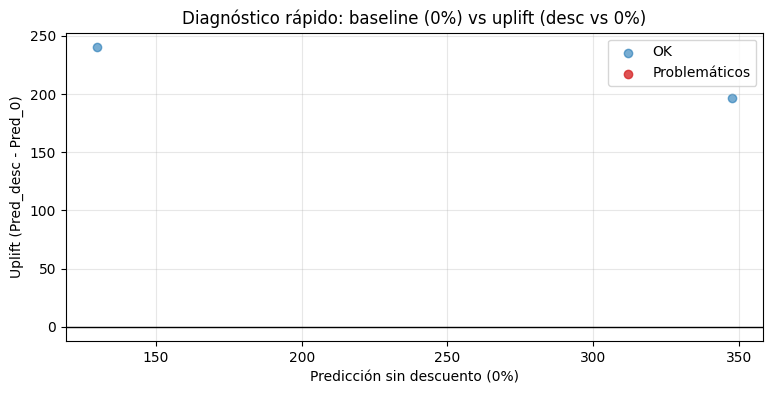

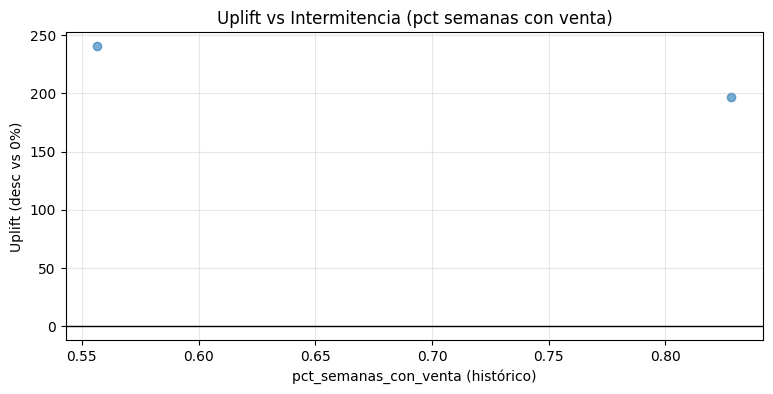

In [17]:
# Parámetros

STORE_CHOICE = "TODAS"
DISC_BASE = 0.20         # descuento objetivo (20% = 0.20)
DELTA = 0.10             # escenarios +/-10pp
TOP_SHOW = 30            # cuantos productos mostrar en ranking
MIN_HIST = 12            # por LAG_12 del simulador

# Preparación
wk_local = wk.copy()
wk_local["PRODUCT_ID"] = wk_local["PRODUCT_ID"].astype(int)
wk_local["STORE_ID"] = wk_local["STORE_ID"].astype(int)
wk_local["WEEK_NO"] = wk_local["WEEK_NO"].astype(int)

def clip_disc(x):
    return float(min(0.90, max(0.0, x)))

d0 = 0.0
d1 = clip_disc(DISC_BASE - DELTA)  # 10% si base=20%
d2 = clip_disc(DISC_BASE)          # 20%
d3 = clip_disc(DISC_BASE + DELTA)  # 30%

# elegimos semana objetivo = última semana global + 1 (t+1)
last_week_global = int(wk_local["WEEK_NO"].max())
week_target = last_week_global + 1

# productos candidatos: los que existen en wk
products = sorted(wk_local["PRODUCT_ID"].unique().tolist())

# función: tiendas elegibles (>=12 filas) para un producto
def eligible_stores(prod, up_to_week):
    hist = wk_local[(wk_local["PRODUCT_ID"]==prod) & (wk_local["WEEK_NO"]<=up_to_week)]
    cnt = hist.groupby("STORE_ID")["WEEK_NO"].count()
    return cnt[cnt >= MIN_HIST].index.tolist()

# Stats rápidos para detectar "por qué falla"
# (intermitencia / poca venta) usando datos hasta last_week_global
hist_cut = wk_local[wk_local["WEEK_NO"] <= last_week_global].copy()
prod_stats = (hist_cut.groupby("PRODUCT_ID")
              .agg(
                  mean_qty=("QUANTITY","mean"),
                  pct_weeks_sale=("QUANTITY", lambda x: (x>0).mean()),
                  weeks_obs=("WEEK_NO","nunique")
              )
              .reset_index())

# Predicciones para ranking
rows = []
for prod in products:
    # si store = TODAS, sumamos solo tiendas elegibles
    if STORE_CHOICE == "TODAS":
        stores = eligible_stores(prod, last_week_global)
        if len(stores) == 0:
            continue  # no se puede evaluar este producto
        def pred_sum(disc):
            vals = []
            for s in stores:
                p = simular_ventas(prod, int(s), int(week_target), float(disc))
                vals.append(np.nan if isinstance(p, str) else float(p))
            return float(np.nansum(vals))
        p0 = pred_sum(d0)
        p1 = pred_sum(d1)
        p2 = pred_sum(d2)
        p3 = pred_sum(d3)
        store_info = f"TODAS({len(stores)})"
    else:
        s = int(STORE_CHOICE)
        # si no hay hist suficiente en esa tienda, saltamos
        n_hist = len(hist_cut[(hist_cut["PRODUCT_ID"]==prod) & (hist_cut["STORE_ID"]==s)])
        if n_hist < MIN_HIST:
            continue
        p0 = simular_ventas(prod, s, int(week_target), float(d0))
        p1 = simular_ventas(prod, s, int(week_target), float(d1))
        p2 = simular_ventas(prod, s, int(week_target), float(d2))
        p3 = simular_ventas(prod, s, int(week_target), float(d3))
        # si devuelve string, lo pasamos a NaN
        p0 = np.nan if isinstance(p0, str) else float(p0)
        p1 = np.nan if isinstance(p1, str) else float(p1)
        p2 = np.nan if isinstance(p2, str) else float(p2)
        p3 = np.nan if isinstance(p3, str) else float(p3)
        store_info = str(s)

    uplift = p2 - p0 if (np.isfinite(p2) and np.isfinite(p0)) else np.nan
    monotonic_ok = (p0 <= p1 <= p2 <= p3) if all(np.isfinite([p0,p1,p2,p3])) else False
    lift_negative = (uplift < 0) if np.isfinite(uplift) else False
    base_too_low = (p0 <= 0.5) if np.isfinite(p0) else True  # umbral ajustable

    rows.append({
        "PRODUCT_ID": prod,
        "STORE": store_info,
        "WEEK_TARGET": week_target,
        "PRED_0": p0,
        f"PRED_{int(d1*100)}": p1,
        f"PRED_{int(d2*100)}": p2,
        f"PRED_{int(d3*100)}": p3,
        "UPLIFT_vs_0": uplift,
        "MONOTONIC_OK": monotonic_ok,
        "LIFT_NEGATIVE": lift_negative,
        "BASE_TOO_LOW": base_too_low
    })

rank_df = pd.DataFrame(rows)

# unir stats
rank_df = rank_df.merge(prod_stats, on="PRODUCT_ID", how="left")

# ordenar por uplift (ranking)
rank_df = rank_df.sort_values("UPLIFT_vs_0", ascending=False).reset_index(drop=True)

print(f" Ranking listo | STORE={STORE_CHOICE} | semana objetivo={week_target} | descuento={int(d2*100)}% (escenarios {int(d1*100)}%/{int(d2*100)}%/{int(d3*100)}%)")

# TOP ranking
display(rank_df.head(TOP_SHOW))

#  Productos “problemáticos” (donde puede fallar el simulador)
problems = rank_df[(~rank_df["MONOTONIC_OK"]) | (rank_df["LIFT_NEGATIVE"]) | (rank_df["BASE_TOO_LOW"])].copy()
print("\n Productos problemáticos (no monotónicos / lift negativo / baseline muy bajo):", len(problems))
display(problems.head(30))

# Gráfico rápido: baseline vs uplift (colorea problemas)
plt.figure(figsize=(9,4))
ok = rank_df["MONOTONIC_OK"] & (~rank_df["LIFT_NEGATIVE"]) & (~rank_df["BASE_TOO_LOW"])
plt.scatter(rank_df.loc[ok,"PRED_0"], rank_df.loc[ok,"UPLIFT_vs_0"], alpha=0.6, label="OK")
plt.scatter(rank_df.loc[~ok,"PRED_0"], rank_df.loc[~ok,"UPLIFT_vs_0"], alpha=0.8, label="Problemáticos", color="#d62728")
plt.axhline(0, color="black", linewidth=1)
plt.title("Diagnóstico rápido: baseline (0%) vs uplift (desc vs 0%)")
plt.xlabel("Predicción sin descuento (0%)")
plt.ylabel("Uplift (Pred_desc - Pred_0)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Indicador clave: ¿los “problemáticos” son los intermitentes?
plt.figure(figsize=(9,4))
plt.scatter(rank_df["pct_weeks_sale"], rank_df["UPLIFT_vs_0"], alpha=0.6)
plt.axhline(0, color="black", linewidth=1)
plt.title("Uplift vs Intermitencia (pct semanas con venta)")
plt.xlabel("pct_semanas_con_venta (histórico)")
plt.ylabel("Uplift (desc vs 0%)")
plt.grid(True, alpha=0.3)
plt.show()

Construimos un score de confianza (0-1) para cada producto con el fin de no mirar solo el uplift esperado, si no que tan fiable parece esa predicción.


 TOP recomendados por RANK_SCORE (uplift * confianza):


,PRODUCT_ID,STORE,PRED_0,UPLIFT_vs_0,CONF_SCORE,RANK_SCORE,MONOTONIC_OK,LIFT_NEGATIVE,BASE_TOO_LOW,pct_weeks_sale,weeks_obs
0,1082185,TODAS(114),347.49,196.67,0.754703,148.427409,True,False,False,0.828292,87
1,995242,TODAS(114),129.91,240.62,0.366664,88.226640,True,False,False,0.556665,87



 Productos con CONF_SCORE>=0.3 y RANK_SCORE>0: 2


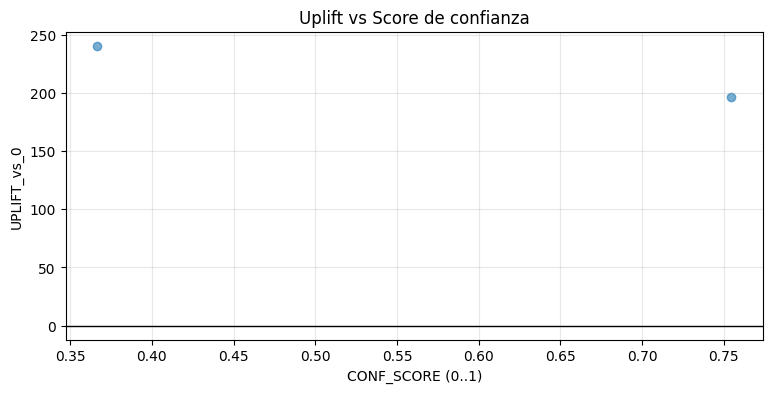

In [18]:

# Componentes normalizados (0..1)

# a) Monotonía: si no es monotónico => 0 (no confiable)
rank_df["conf_monotonic"] = rank_df["MONOTONIC_OK"].astype(int)

# b) Baseline strength: si PRED_0 es muy bajo, poca confianza.
#    Escalamos con una función suave: conf_base = min(1, PRED_0 / t)
#    (t=2 unidades es un umbral razonable; ajusta si quieres)
t_base = 2.0
rank_df["conf_base"] = np.clip(rank_df["PRED_0"] / t_base, 0, 1)

# ¿Qué mide?

# Si el baseline (ventas con 0% descuento) es MUY BAJO, el uplift es poco confiable
# Productos que venden casi 0 tienen predicciones más volátiles

# c) Intermitencia: pct_weeks_sale ya está en 0..1 (más alto => más confianza)
#    Le damos un mínimo: por debajo de 0.30 penaliza fuerte
rank_df["conf_sale_freq"] = np.clip((rank_df["pct_weeks_sale"] - 0.30) / (1.00 - 0.30), 0, 1)

# ¿Qué mide?

# Productos que venden SOLO en pocas semanas son difíciles de predecir
# pct_weeks_sale = % de semanas con al menos 1 venta

# d) Tamaño de muestra: weeks_obs (número de semanas observadas)
#    Normalizamos: conf_weeks = min(1, weeks_obs / 40)
#    (40 semanas ~ suficiente para estimar patrones; ajusta si quieres)
t_weeks = 40.0
rank_df["conf_weeks"] = np.clip(rank_df["weeks_obs"] / t_weeks, 0, 1)

# ¿Qué mide?

# Cuantas más semanas observadas, más robusto el patrón
# Con pocas semanas, el modelo puede sobreajustar

# Penalizaciones claras
# Si lift es negativo => confianza 0 (no recomendar para promo)
rank_df.loc[rank_df["LIFT_NEGATIVE"] == True, "conf_monotonic"] = 0

# Score final de confianza (0..1)
#    Multiplicativo: si falla una condición clave, baja rápido (lo cual es deseable).
rank_df["CONF_SCORE"] = (
    rank_df["conf_monotonic"]
    * rank_df["conf_base"]
    * rank_df["conf_sale_freq"]
    * rank_df["conf_weeks"]
)
# ¿Qué hace?

# Multiplica los 4 componentes
# Si ALGUNO falla → score bajo
# Solo productos que pasan TODOS los checks tienen score alto

# Ranking final: uplift ponderado por confianza
rank_df["RANK_SCORE"] = rank_df["UPLIFT_vs_0"] * rank_df["CONF_SCORE"]

# ¿Qué hace?

# Combina UPLIFT (cuánto sube) con CONFIANZA (cuán fiable es)
# Productos con alto uplift PERO baja confianza → bajan en ranking

#  TOP productos para promo
recom = (rank_df
         .sort_values("RANK_SCORE", ascending=False)
         .reset_index(drop=True))

print("\n TOP recomendados por RANK_SCORE (uplift * confianza):")
display(recom.head(20)[[
    "PRODUCT_ID","STORE","PRED_0","UPLIFT_vs_0",
    "CONF_SCORE","RANK_SCORE",
    "MONOTONIC_OK","LIFT_NEGATIVE","BASE_TOO_LOW",
    "pct_weeks_sale","weeks_obs"
]])

# ¿cuántos quedan como “buenos”?
good = recom[(recom["CONF_SCORE"] >= 0.3) & (recom["RANK_SCORE"] > 0)].copy()
print(f"\n Productos con CONF_SCORE>=0.3 y RANK_SCORE>0: {len(good)}")

# 7)  Uplift vs Confianza (para ver si fallan por algo concreto)
plt.figure(figsize=(9,4))
plt.scatter(recom["CONF_SCORE"], recom["UPLIFT_vs_0"], alpha=0.6)
plt.axhline(0, color="black", linewidth=1)
plt.title("Uplift vs Score de confianza")
plt.xlabel("CONF_SCORE (0..1)")
plt.ylabel("UPLIFT_vs_0")
plt.grid(True, alpha=0.3)
plt.show()


Para priorizar productos a promocionar, no basta con ordenar por uplift estimado. Se introduce un score de confianza (0–1) que pondera el uplift según: (i) coherencia monotónica de la respuesta al descuento, (ii) nivel base de ventas, (iii) frecuencia de semanas con venta (intermitencia) y (iv) tamaño de muestra. El ranking final se define como uplift × confianza, evitando recomendar productos con estimaciones inestables.

## 8. Resultados y Conclusiones

### Métricas Finales

- **MAE Modelo B:** 1.22 unidades (XGBoost)
- **MAE Modelo B:** 1.27 unidades (CatBoost)
- **MAE Modelo B:** 1.36 unidades (Linear)
- **R² Modelo A:** 0.471
- **Productos modelables:** 2 (de 99 iniciales tras filtrado)

### Limitaciones

El dataset The Complete Journey presenta demanda altamente intermitente, con la mayoría de productos vendiendo menos de 2 unidades por semana. Esto limita la aplicabilidad de modelos de elasticidad precio tradicional.

Solo 2 productos cumplieron los criterios de modelabilidad establecidos (≥2 uds/semana, presencia ≥40%), lo que refleja la realidad de muchos SKUs en retail: baja rotación y ventas esporádicas.

### Simulador

Se desarrolló un simulador para proyectar ventas futuras a partir del histórico (lags LAG_1, LAG_2, LAG_4, LAG_12), estacionalidad semanal (WEEK_SIN/WEEK_COS) y un descuento objetivo, permitiendo analizar escenarios tipo:

Baseline (0%)
Descuento base (p.ej. 20%)
Escenarios ±Δ (p.ej. 10% y 30%)

Para el caso agregado STORE=TODAS, el simulador suma predicciones únicamente de tiendas “elegibles” (con histórico suficiente ≥12 observaciones), garantizando consistencia con las features de lag.

### Conclusión

El enfoque de dos etapas (baseline + lift incremental) demostró ser efectivo para productos con demanda suficiente:

1. **Modelo A (Baseline)** captura correctamente el nivel base de demanda sin promoción
2. **Modelo B (Lift)** estima el incremento de ventas causado por descuentos
3. **Simulador** permite evaluar escenarios promocionales de forma coherente y monotónica

El MAE de 1.22 unidades sobre productos que venden 2-3 unidades/semana es razonable para este contexto de demanda intermitente. El objetivo no es predecir ventas exactas, sino estimar correctamente el efecto relativo de promociones para priorización y toma de decisiones.

